In [164]:
library("dslabs")
library("dplyr")
library("Hmisc")
library("ggplot2")
library("DescTools")
library("aod")
library("car")
library("lmtest")
library("pROC")
library("xtable")
library("gam")
library("caret")
library("glmnet")
library("glmnetUtils")
library("pander")
library("lme4")
theme_update(plot.title = element_text(hjust = 0.5))

## Read and Clean Data

In [165]:
framingham_data = read.csv("framingham_multi.csv")
# summary of data
summary(framingham_data)

     RANDID             SEX           TOTCHOL           AGE       
 Min.   :   6238   Min.   :1.000   Min.   :135.0   Min.   :33.00  
 1st Qu.: 641740   1st Qu.:1.000   1st Qu.:209.0   1st Qu.:47.00  
 Median :1213108   Median :2.000   Median :238.0   Median :54.00  
 Mean   :1232440   Mean   :1.532   Mean   :239.8   Mean   :54.11  
 3rd Qu.:1833807   3rd Qu.:2.000   3rd Qu.:266.0   3rd Qu.:61.00  
 Max.   :2460331   Max.   :2.000   Max.   :625.0   Max.   :79.00  
     SYSBP           DIABP           CURSMOKE        CIGPDAY      
 Min.   : 92.5   Min.   : 52.00   Min.   :0.000   Min.   : 0.000  
 1st Qu.:120.0   1st Qu.: 75.00   1st Qu.:0.000   1st Qu.: 0.000  
 Median :131.5   Median : 82.00   Median :0.000   Median : 0.000  
 Mean   :134.7   Mean   : 82.73   Mean   :0.416   Mean   : 8.187  
 3rd Qu.:147.1   3rd Qu.: 90.00   3rd Qu.:1.000   3rd Qu.:20.000  
 Max.   :246.0   Max.   :127.00   Max.   :1.000   Max.   :90.000  
      BMI           DIABETES          HEARTRTE         GLUCOSE

In [166]:
describe(framingham_data)

framingham_data 

 16  Variables      1500  Observations
--------------------------------------------------------------------------------
RANDID 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
    1500        0      500        1  1232440   807581   126460   224615 
     .25      .50      .75      .90      .95 
  641740  1213108  1833807  2213833  2318599 

lowest :    6238   11263   14367   16365   23727
highest: 2422371 2428234 2437351 2441847 2460331
--------------------------------------------------------------------------------
SEX 
       n  missing distinct     Info     Mean      Gmd 
    1500        0        2    0.747    1.532   0.4983 
                      
Value          1     2
Frequency    702   798
Proportion 0.468 0.532
--------------------------------------------------------------------------------
TOTCHOL 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
    1500        0      210        1    239.8    49.42    171.0    

In [264]:
framingham_data_clean = framingham_data
framingham_data_clean$SEX = as.factor(framingham_data_clean$SEX)
framingham_data_clean$CURSMOKE = as.factor(framingham_data_clean$CURSMOKE)
framingham_data_clean$DIABETES = as.factor(framingham_data_clean$DIABETES)
framingham_data_clean$PREVHYP = as.factor(framingham_data_clean$PREVHYP)
framingham_data_clean$EDUC = as.factor(framingham_data_clean$EDUC)
framingham_data_clean$PERIOD = as.factor(framingham_data_clean$PERIOD)

In [168]:
train_idx = createDataPartition(framingham_data_clean$PREVHYP, p=0.75, list=F)[,1]
train_data = framingham_data_clean[train_idx,]
test_data = framingham_data_clean[-train_idx,]

## EDA

In [169]:
# tables of each input feature with the response
chisq_cont_table = function(feature, row_names) {
    tbl = table(feature, framingham_data_clean$PREVHYP)
    colnames(tbl) = c("free of disease", "prevalent disease")
    rownames(tbl) = row_names
    print(tbl)
    print(chisq.test(tbl))
    print(pandoc.table(tbl))
}

In [170]:
chisq_cont_table(framingham_data_clean$SEX, c("Male", "Female"))

        
feature  free of disease prevalent disease
  Male               366               336
  Female             453               345

	Pearson's Chi-squared test with Yates' continuity correction

data:  tbl
X-squared = 3.0458, df = 1, p-value = 0.08094



|   &nbsp;   | free of disease | prevalent disease |
|:----------:|:---------------:|:-----------------:|
|  **Male**  |       366       |        336        |
| **Female** |       453       |        345        |

NULL


In [171]:
chisq_cont_table(framingham_data_clean$CURSMOKE, c("Yes", "No"))

       
feature free of disease prevalent disease
    Yes             420               456
    No              399               225

	Pearson's Chi-squared test with Yates' continuity correction

data:  tbl
X-squared = 36.979, df = 1, p-value = 1.194e-09



| &nbsp;  | free of disease | prevalent disease |
|:-------:|:---------------:|:-----------------:|
| **Yes** |       420       |        456        |
| **No**  |       399       |        225        |

NULL


In [172]:
chisq_cont_table(framingham_data_clean$DIABETES, c("Not Diabetic", "Diabetic"))

              
feature        free of disease prevalent disease
  Not Diabetic             811               634
  Diabetic                   8                47

	Pearson's Chi-squared test with Yates' continuity correction

data:  tbl
X-squared = 35.294, df = 1, p-value = 2.835e-09



|      &nbsp;      | free of disease | prevalent disease |
|:----------------:|:---------------:|:-----------------:|
| **Not Diabetic** |       811       |        634        |
|   **Diabetic**   |        8        |        47         |

NULL


In [173]:
chisq_cont_table(framingham_data_clean$EDUC, c("0-11 years", "High School Diploma or GED", "Some College or Vocational School", "College degree or more"))

                                   
feature                             free of disease prevalent disease
  0-11 years                                    287               295
  High School Diploma or GED                    274               212
  Some College or Vocational School             153                96
  College degree or more                        105                78

	Pearson's Chi-squared test

data:  tbl
X-squared = 12.461, df = 3, p-value = 0.005961



|                &nbsp;                 | free of disease | prevalent disease |
|:-------------------------------------:|:---------------:|:-----------------:|
|            **0-11 years**             |       287       |        295        |
|    **High School Diploma or GED**     |       274       |        212        |
| **Some College or Vocational School** |       153       |        96         |
|      **College degree or more**       |       105       |        78         |

NULL


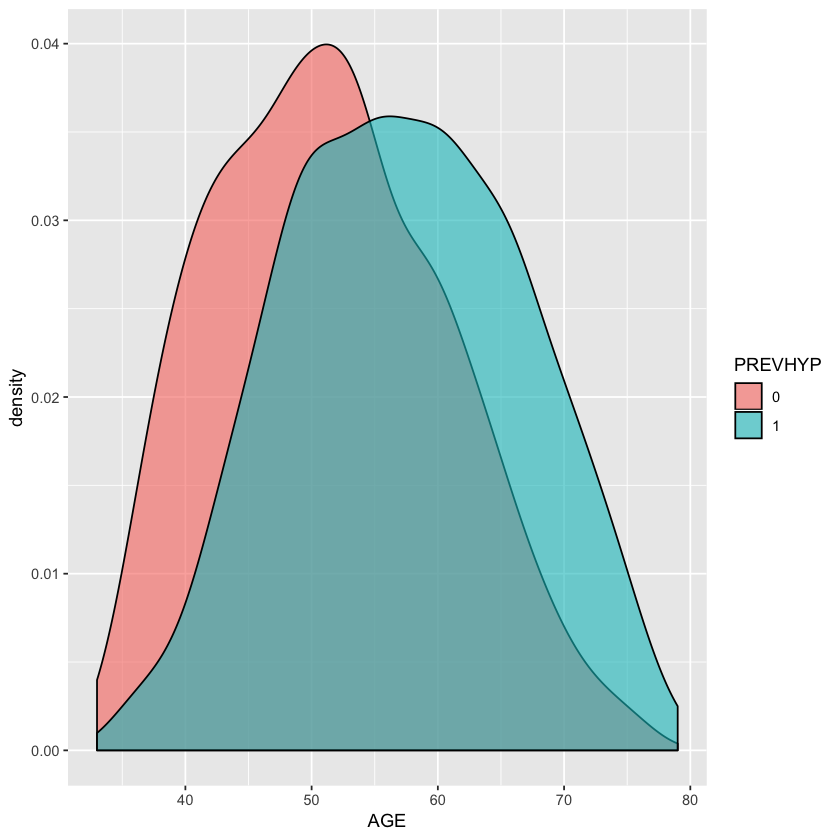

In [175]:
ggplot(data=framingham_data_clean, aes(x=AGE, fill=PREVHYP)) +
    geom_density(alpha=.6)

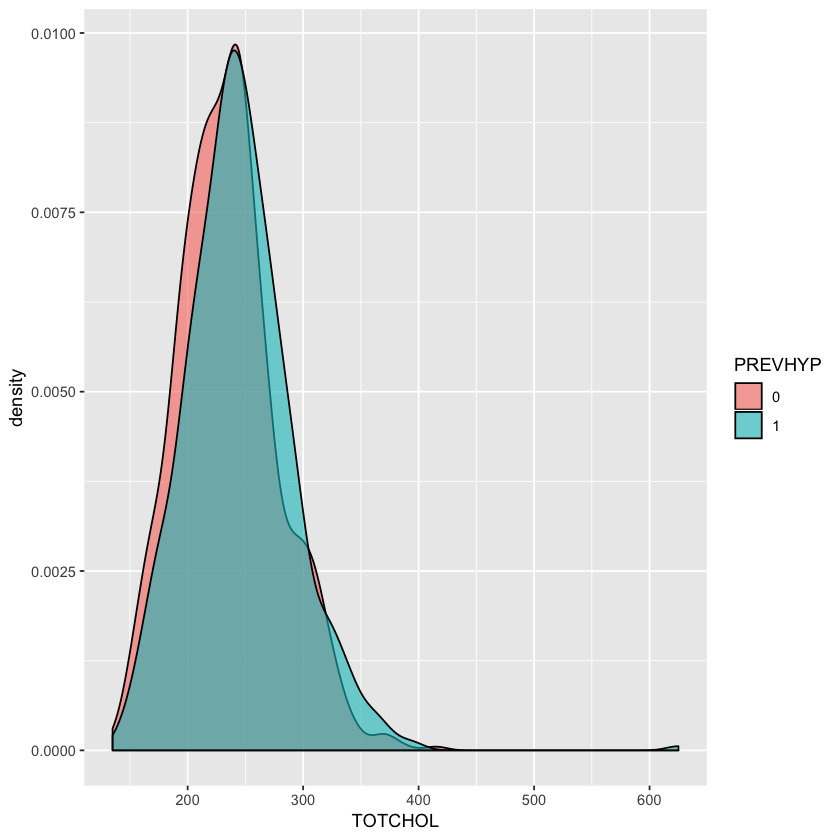

In [176]:
ggplot(data=framingham_data_clean, aes(x=TOTCHOL, fill=PREVHYP)) +
    geom_density(alpha=.6)

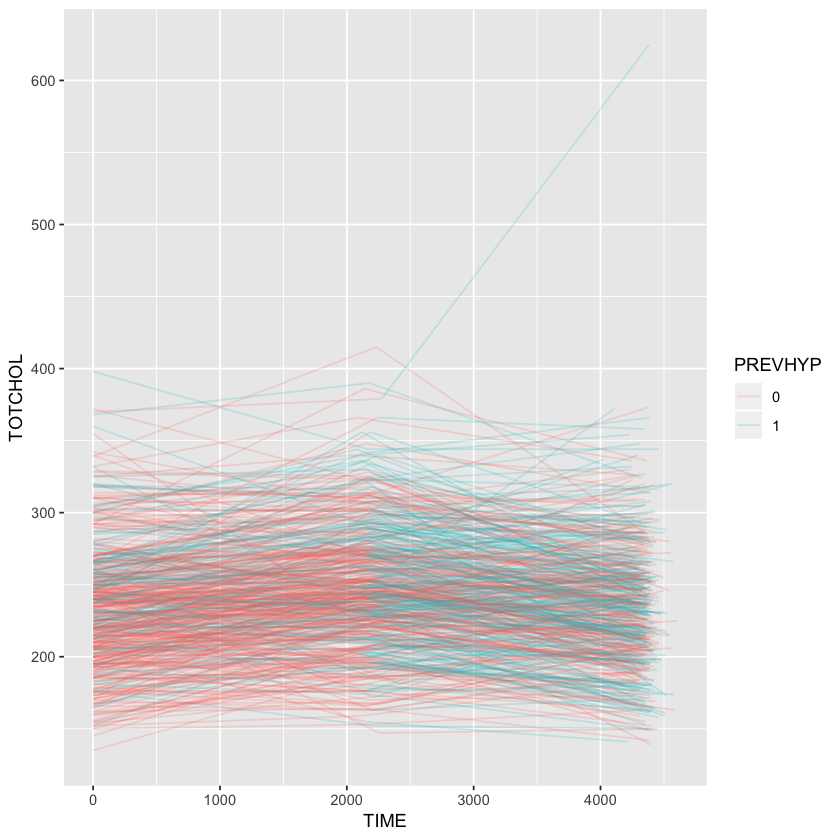

In [177]:
ggplot(data=framingham_data_clean, aes(x=TIME, y=TOTCHOL, group=RANDID, color=PREVHYP)) +
    geom_line(alpha=.2)

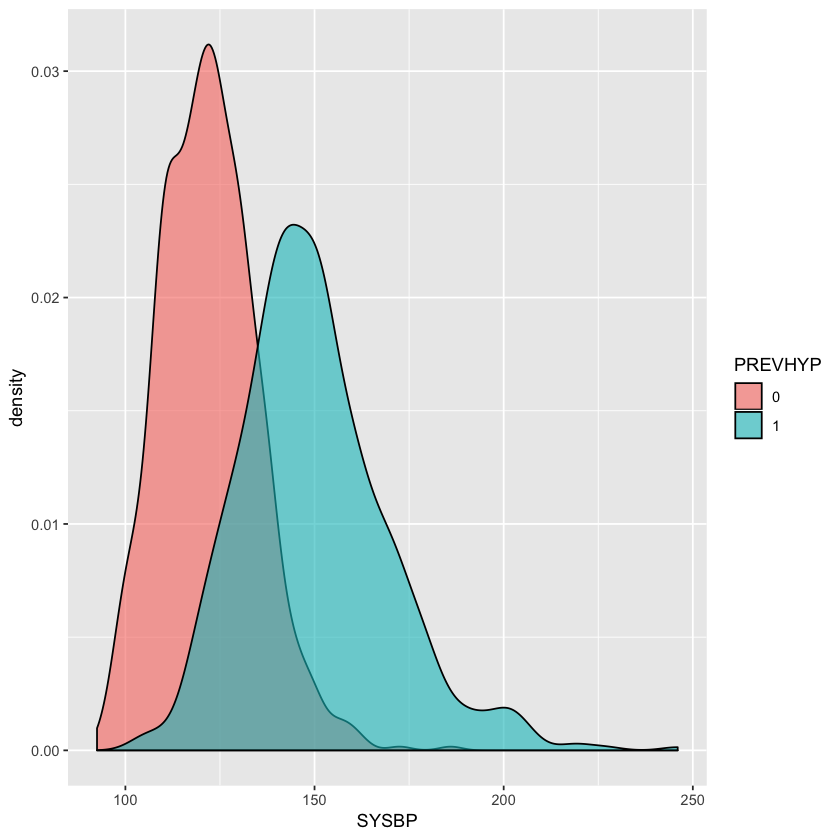

In [178]:
ggplot(data=framingham_data_clean, aes(x=SYSBP, fill=PREVHYP)) +
    geom_density(alpha=.6)

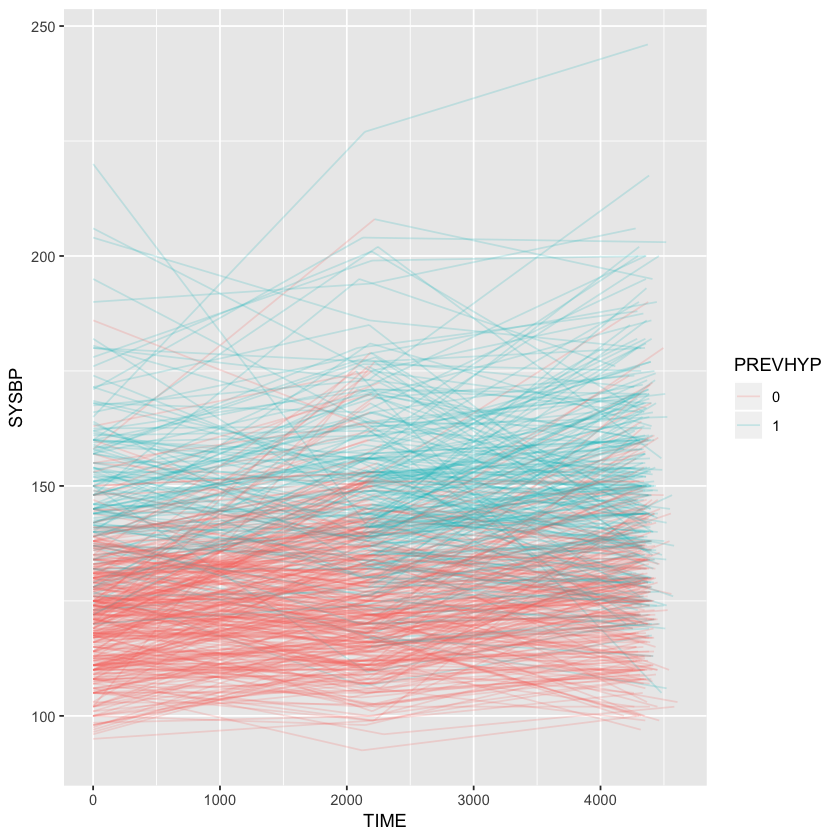

In [181]:
ggplot(data=framingham_data_clean, aes(x=TIME, y=SYSBP, group=RANDID, color=PREVHYP)) +
    geom_line(alpha=.2)

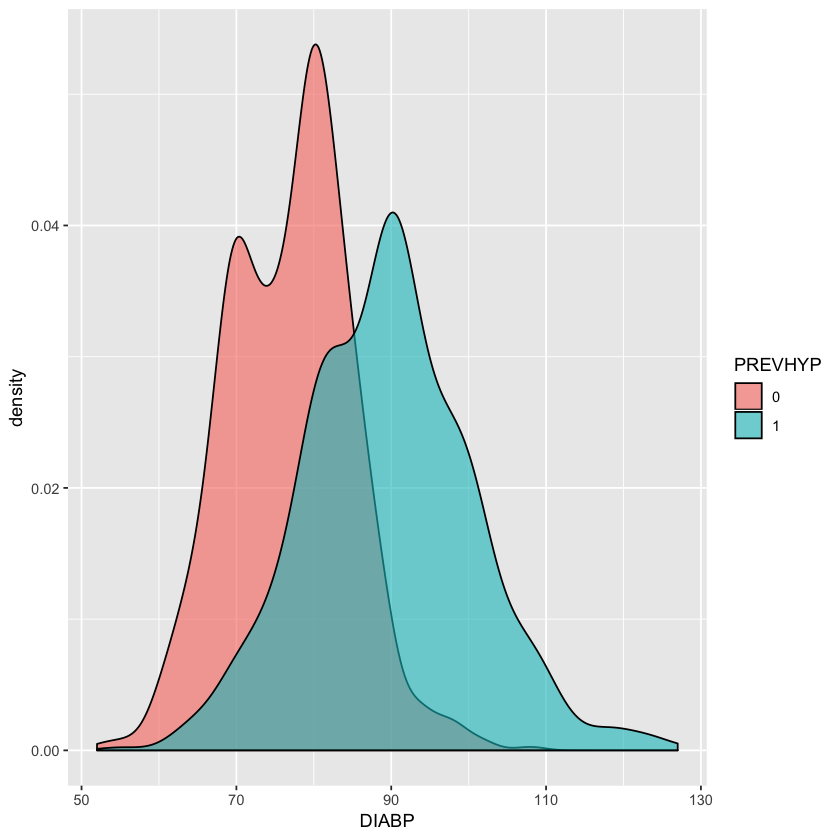

In [64]:
ggplot(data=framingham_data_clean, aes(x=DIABP, fill=PREVHYP)) +
    geom_density(alpha=.6)

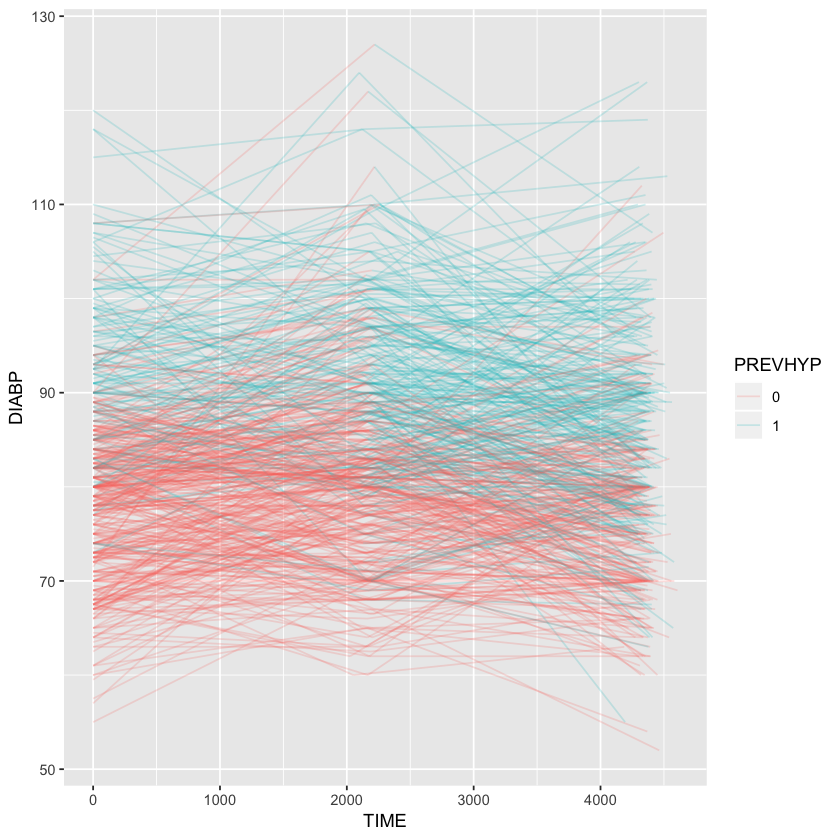

In [182]:
ggplot(data=framingham_data_clean, aes(x=TIME, y=DIABP, group=RANDID, color=PREVHYP)) +
    geom_line(alpha=.2)

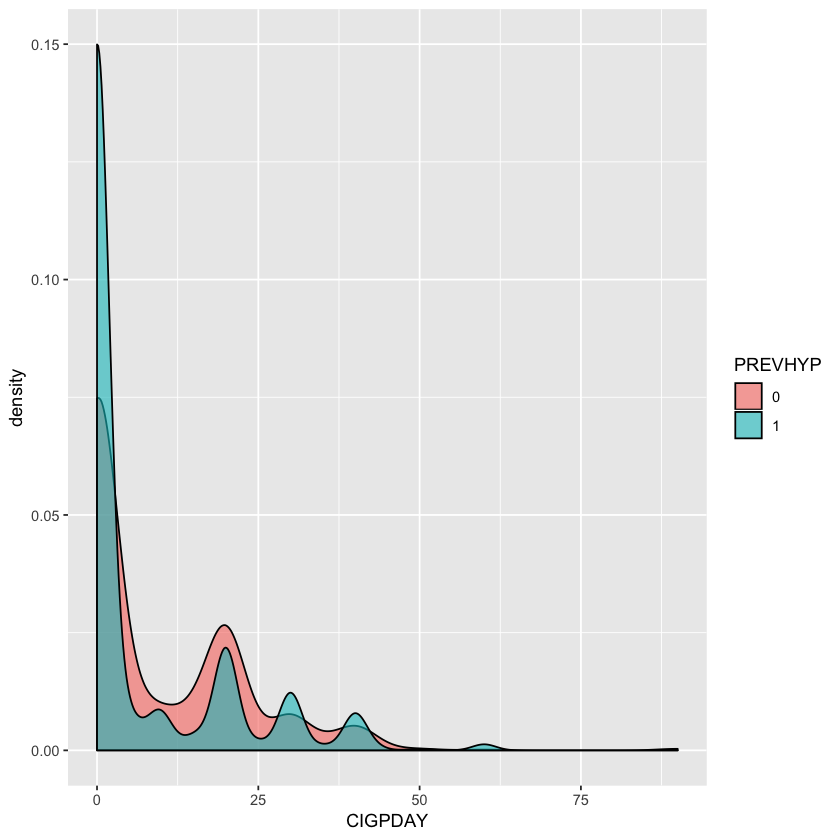

In [23]:
ggplot(data=framingham_data_clean, aes(x=CIGPDAY, fill=PREVHYP)) +
    geom_density(alpha=.6)

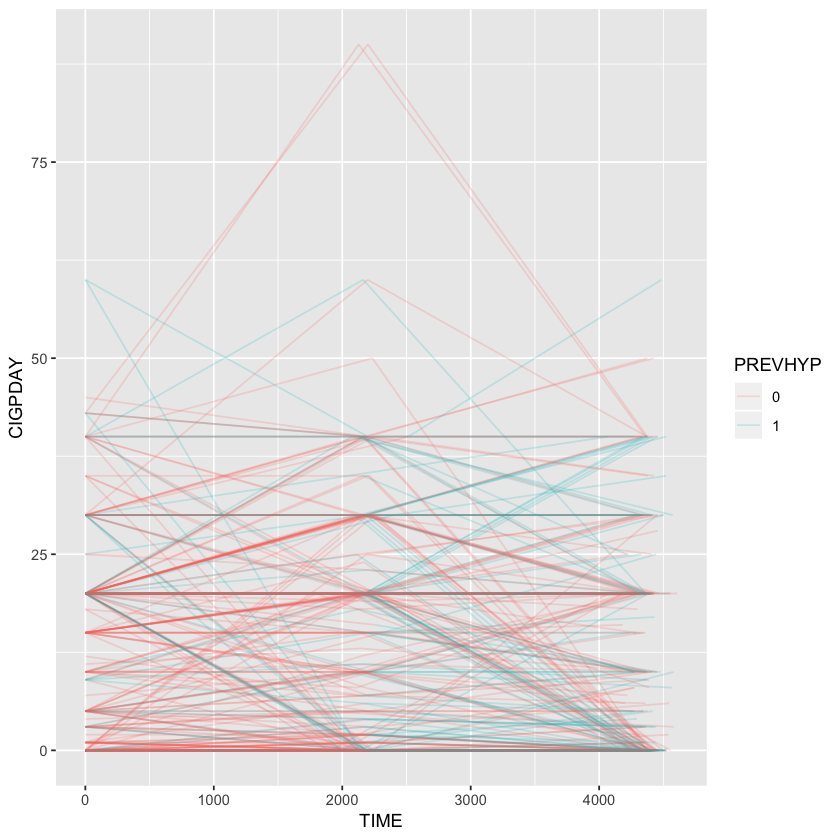

In [183]:
ggplot(data=framingham_data_clean, aes(x=TIME, y=CIGPDAY, group=RANDID, color=PREVHYP)) +
    geom_line(alpha=.2)

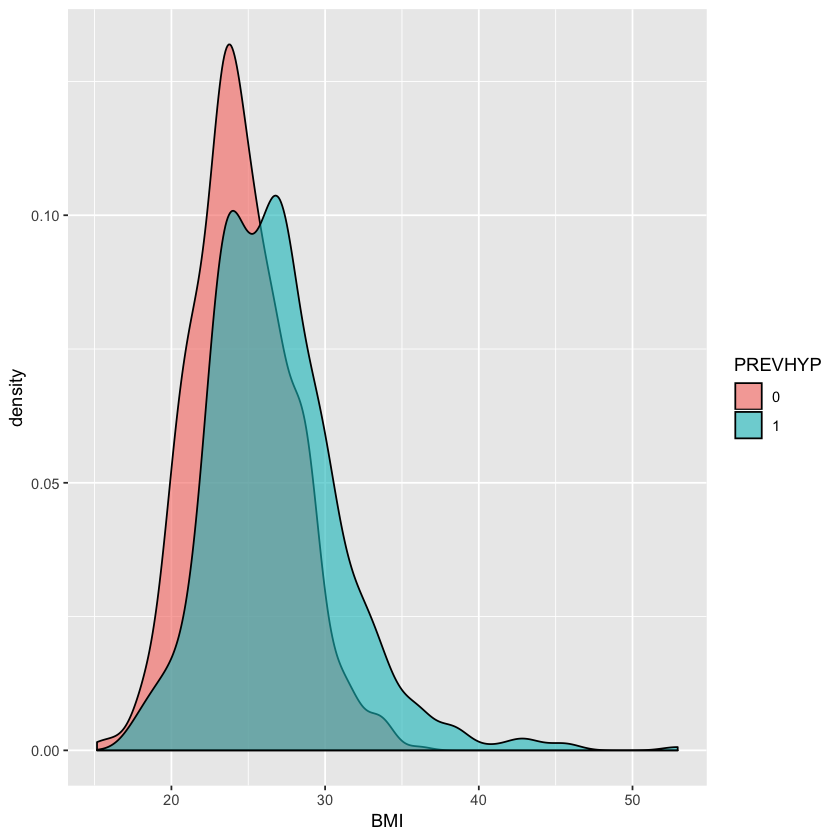

In [24]:
ggplot(data=framingham_data_clean, aes(x=BMI, fill=PREVHYP)) +
    geom_density(alpha=.6)

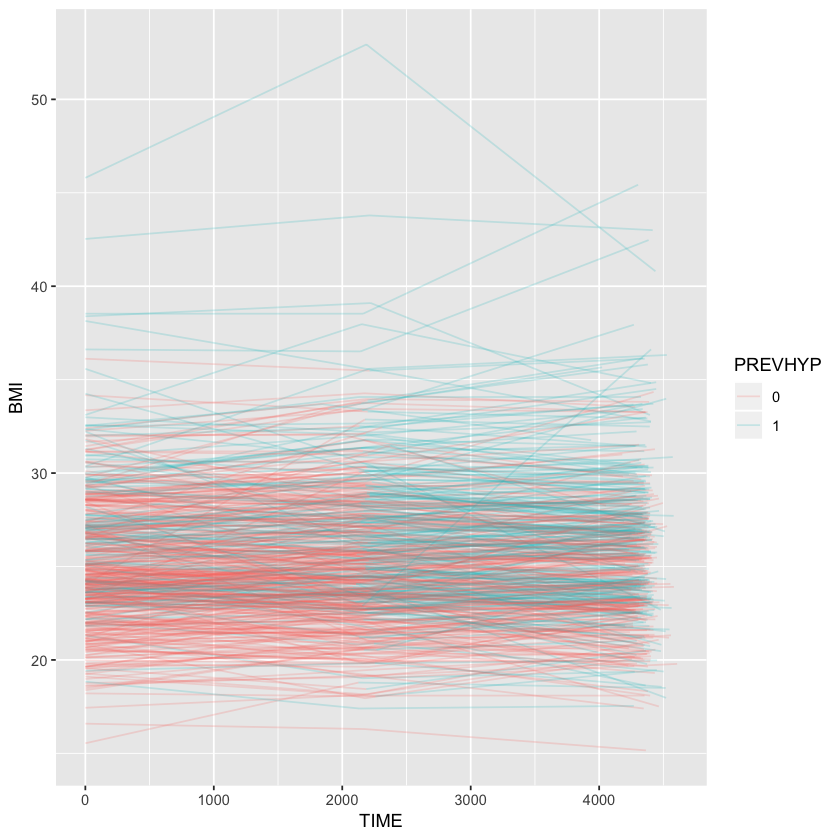

In [184]:
ggplot(data=framingham_data_clean, aes(x=TIME, y=BMI, group=RANDID, color=PREVHYP)) +
    geom_line(alpha=.2)

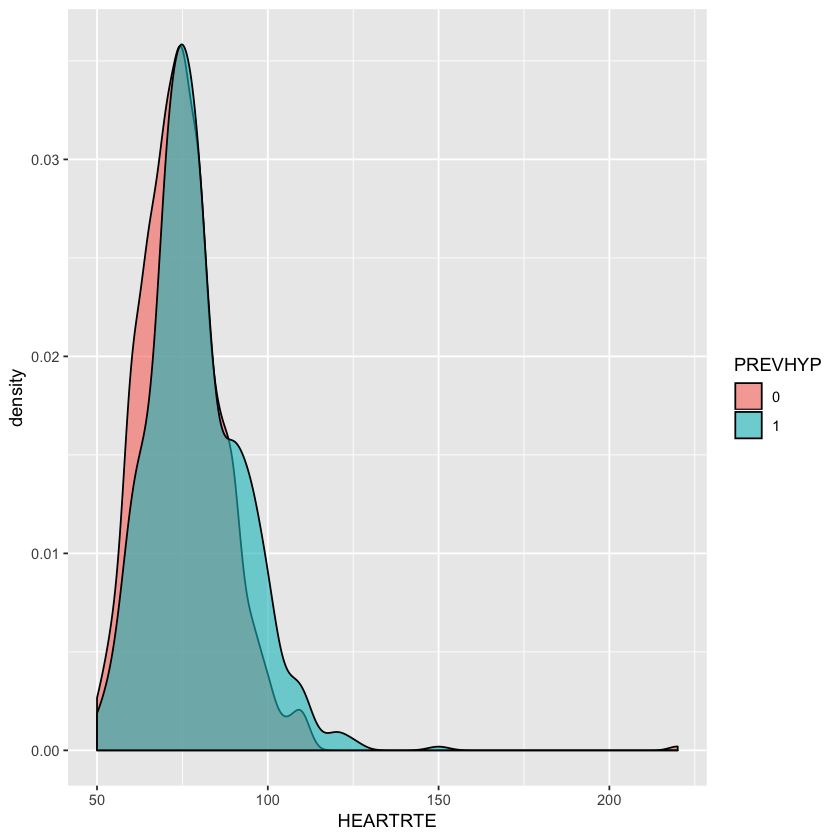

In [25]:
ggplot(data=framingham_data_clean, aes(x=HEARTRTE, fill=PREVHYP)) +
    geom_density(alpha=.6)

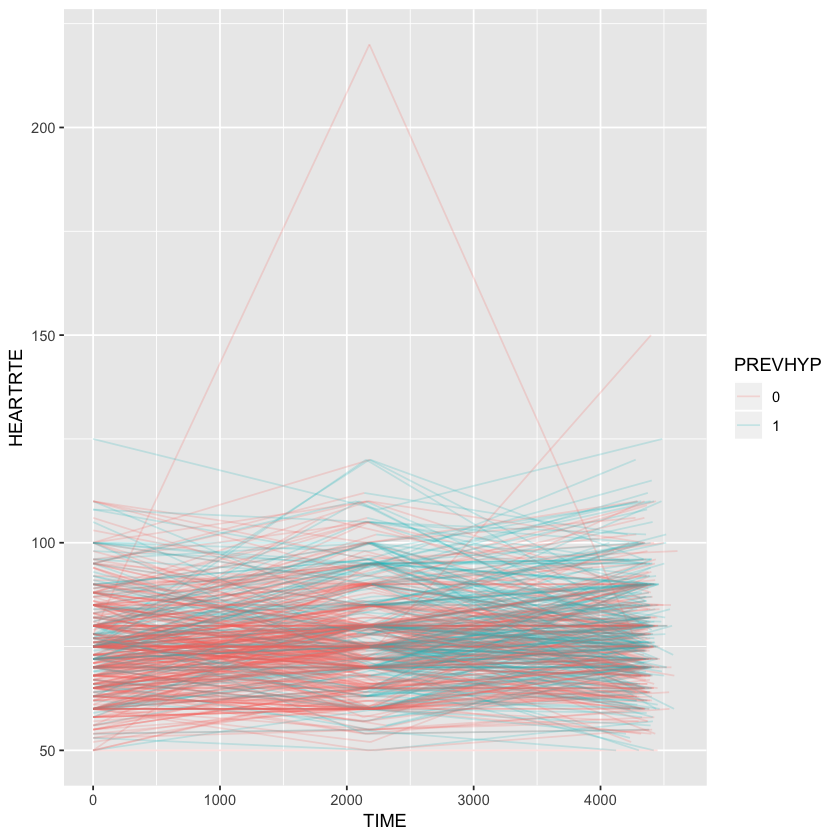

In [185]:
ggplot(data=framingham_data_clean, aes(x=TIME, y=HEARTRTE, group=RANDID, color=PREVHYP)) +
    geom_line(alpha=.2)

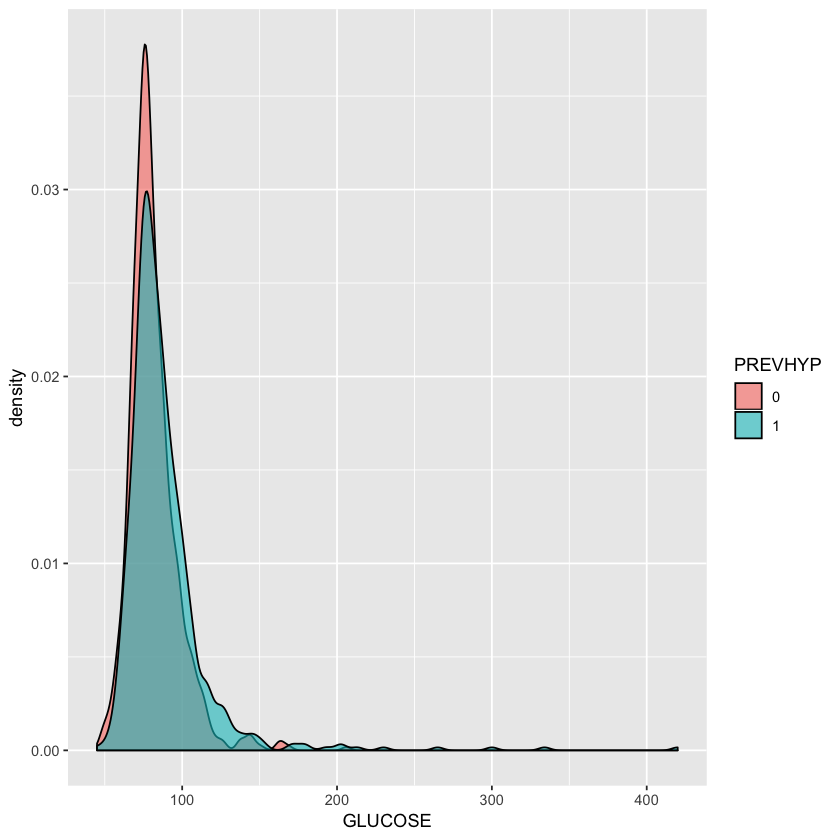

In [26]:
ggplot(data=framingham_data_clean, aes(x=GLUCOSE, fill=PREVHYP)) +
    geom_density(alpha=.6)

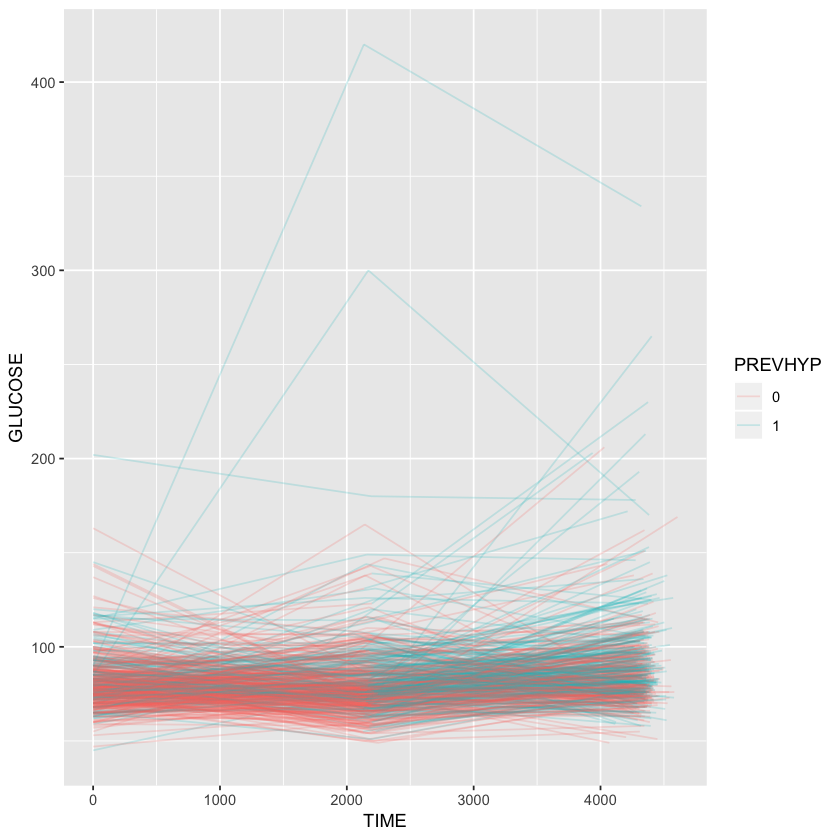

In [186]:
ggplot(data=framingham_data_clean, aes(x=TIME, y=GLUCOSE, group=RANDID, color=PREVHYP)) +
    geom_line(alpha=.2)

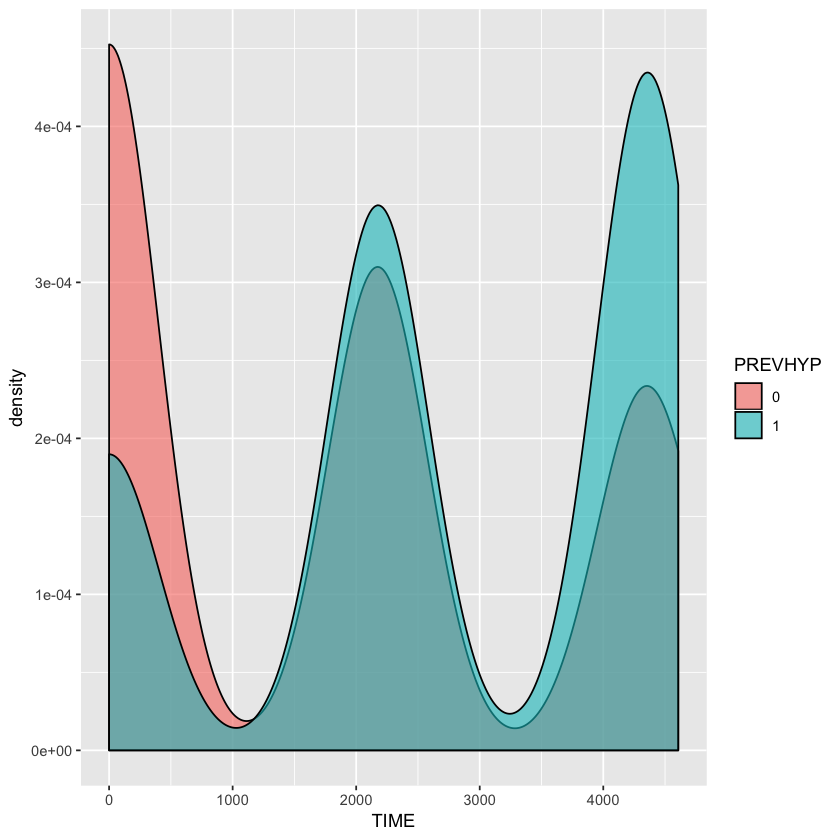

In [27]:
ggplot(data=framingham_data_clean, aes(x=TIME, fill=PREVHYP)) +
    geom_density(alpha=.6)

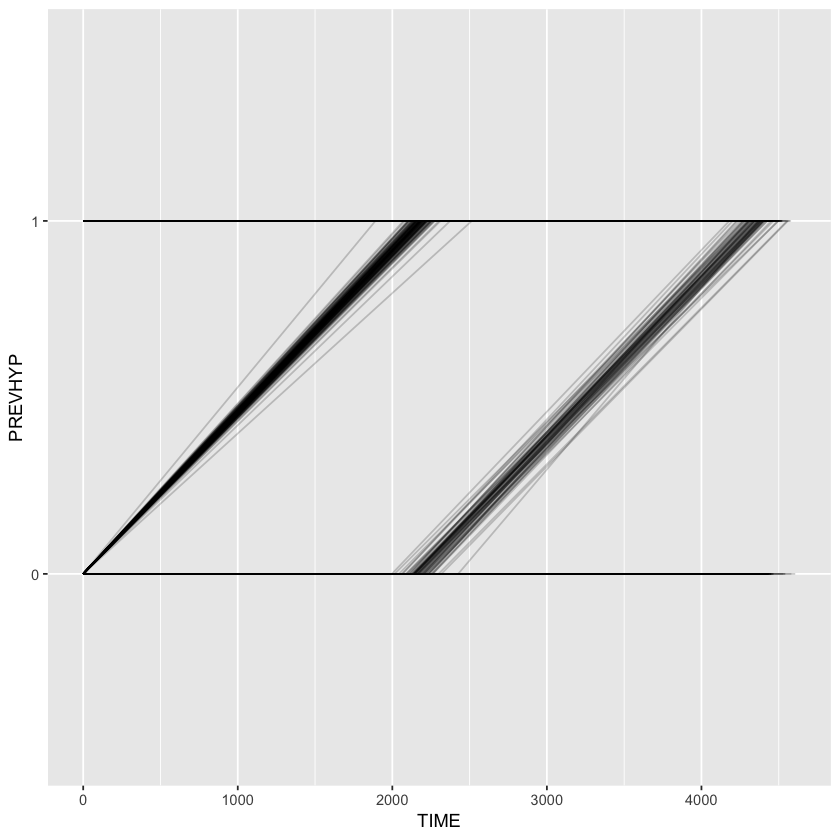

In [188]:
ggplot(data=framingham_data_clean, aes(x=TIME, y=PREVHYP, group=RANDID)) +
    geom_line(alpha=.2)

## Model Fitting

In [267]:
# all variables, random intercept
model_1 = glmer(PREVHYP ~ SEX + TOTCHOL + AGE + SYSBP + DIABP + CURSMOKE + CIGPDAY + BMI + DIABETES + HEARTRTE + GLUCOSE + EDUC + TIME + PERIOD + (1 | RANDID),
                data=framingham_data_clean,
                family=binomial)
summary(model_1)

Warning message:
“Some predictor variables are on very different scales: consider rescaling”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”Warning message in vcov.merMod(object, use.hessian = use.hessian):
“variance-covariance matrix computed from finite-difference Hessian is
not positive definite or contains NA values: falling back to var-cov estimated from RX”Warning message in vcov.merMod(object, correlation = correlation, sigm = sig):
“variance-covariance matrix computed from finite-difference Hessian is
not positive definite or contains NA values: falling back to var-cov estimated from RX”
Correlation matrix not shown by default, as p = 18 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: PREVHYP ~ SEX + TOTCHOL + AGE + SYSBP + DIABP + CURSMOKE + CIGPDAY +  
    BMI + DIABETES + HEARTRTE + GLUCOSE + EDUC + TIME + PERIOD +  
    (1 | RANDID)
   Data: framingham_data_clean

     AIC      BIC   logLik deviance df.resid 
   952.4   1053.4   -457.2    914.4     1481 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1150 -0.1491 -0.0124  0.1540  6.2290 

Random effects:
 Groups Name        Variance Std.Dev.
 RANDID (Intercept) 5.652    2.377   
Number of obs: 1500, groups:  RANDID, 500

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -37.576625   2.937844 -12.791  < 2e-16 ***
SEX2         -0.492451   0.341600  -1.442   0.1494    
TOTCHOL       0.001272   0.003520   0.361   0.7178    
AGE           0.031290   0.022034   1.420   0.1556    
SYSBP         0.136116   0.013869   9.814  < 2e-16 ***
DIABP 

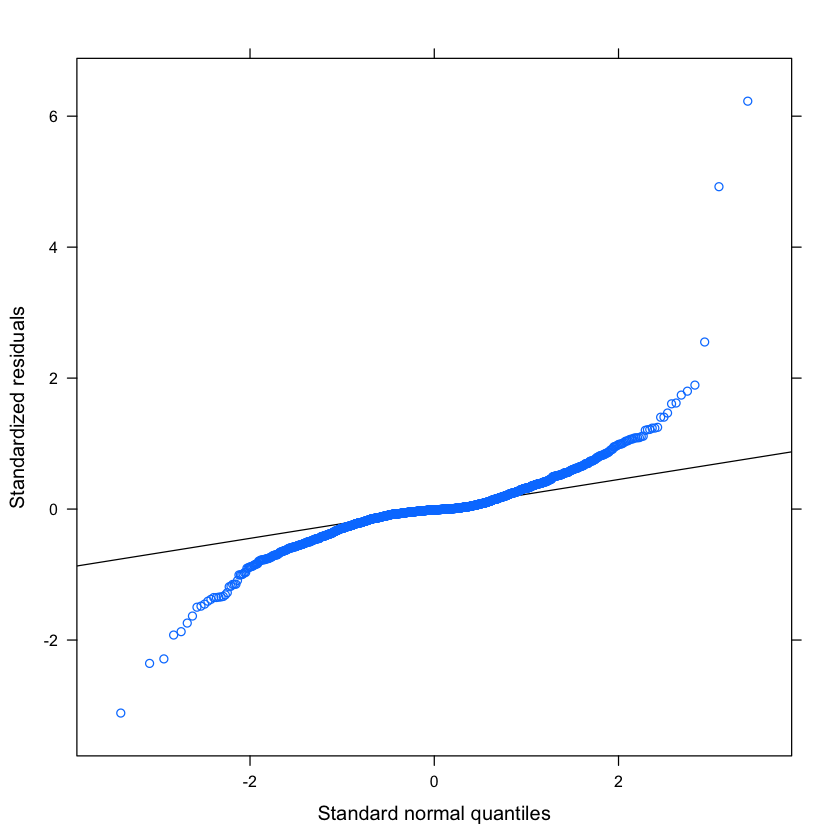

In [268]:
qqmath(model_1)

In [269]:
# all variables, random intercept, no period as it is just a categorical of time
model_2 = glmer(PREVHYP ~ SEX + TOTCHOL + AGE + SYSBP + DIABP + CURSMOKE + CIGPDAY + BMI + DIABETES + HEARTRTE + GLUCOSE + EDUC + TIME + (1 | RANDID),
                data=framingham_data_clean,
                family=binomial)
summary(model_2)

Warning message:
“Some predictor variables are on very different scales: consider rescaling”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 39.8421 (tol = 0.001, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?;Model is nearly unidentifiable: large eigenvalue ratio
 - Rescale variables?”
Correlation matrix not shown by default, as p = 16 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: PREVHYP ~ SEX + TOTCHOL + AGE + SYSBP + DIABP + CURSMOKE + CIGPDAY +  
    BMI + DIABETES + HEARTRTE + GLUCOSE + EDUC + TIME + (1 |      RANDID)
   Data: framingham_data_clean

     AIC      BIC   logLik deviance df.resid 
   950.3   1040.6   -458.1    916.3     1483 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9992 -0.1366 -0.0087  0.1399  6.0459 

Random effects:
 Groups Name        Variance Std.Dev.
 RANDID (Intercept) 6.491    2.548   
Number of obs: 1500, groups:  RANDID, 500

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.236e+01  5.261e+00  -8.051 8.20e-16 ***
SEX2        -8.678e-01  3.858e-01  -2.249 0.024514 *  
TOTCHOL      3.201e-03  3.520e-03   0.909 0.363100    
AGE          7.351e-02  2.785e-02   2.639 0.008312 ** 
SYSBP        1.268e-01  1.617e-02   7.843 4.40e-15 ***
DIABP        1.4

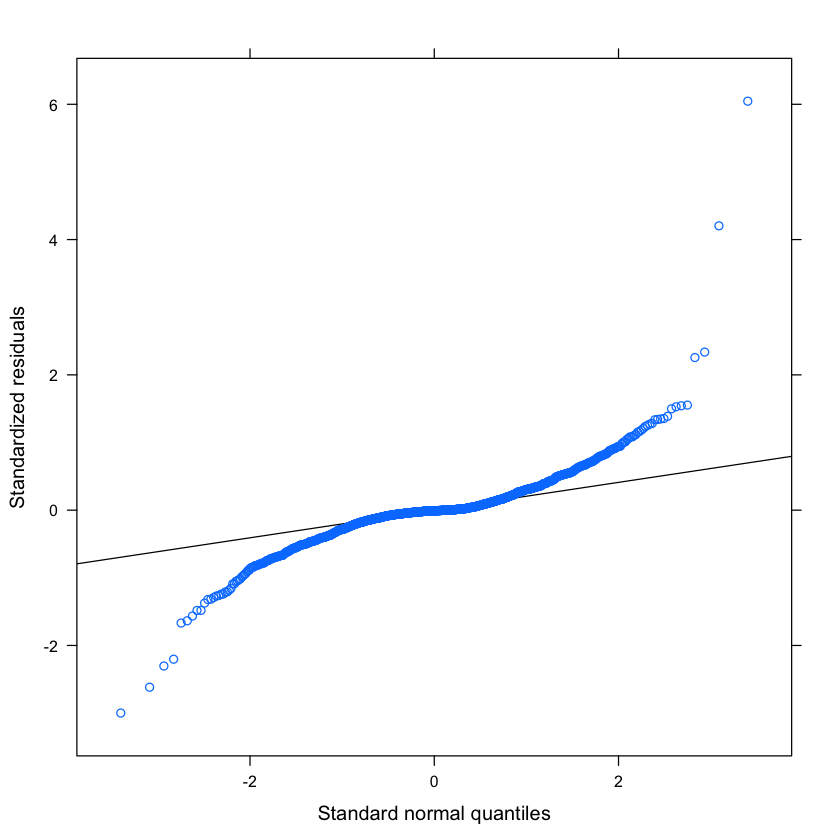

In [270]:
qqmath(model_2)

In [271]:
# all with significant p values below .05 and trajectories that look different in the chart, random intercept
model_3 = glmer(PREVHYP ~ CIGPDAY + SYSBP + CURSMOKE + DIABETES + EDUC + (1 | RANDID),
                data=framingham_data_clean,
                family=binomial)
summary(model_3)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 3.80408 (tol = 0.001, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?;Model is nearly unidentifiable: large eigenvalue ratio
 - Rescale variables?”

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: PREVHYP ~ CIGPDAY + SYSBP + CURSMOKE + DIABETES + EDUC + (1 |  
    RANDID)
   Data: framingham_data_clean

     AIC      BIC   logLik deviance df.resid 
  1149.5   1197.3   -565.7   1131.5     1491 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-13.5308  -0.3015  -0.0856   0.2880   8.7529 

Random effects:
 Groups Name        Variance Std.Dev.
 RANDID (Intercept) 1.899    1.378   
Number of obs: 1500, groups:  RANDID, 500

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -19.922627   1.343785 -14.826  < 2e-16 ***
CIGPDAY       0.007149   0.012501   0.572  0.56739    
SYSBP         0.147722   0.009812  15.055  < 2e-16 ***
CURSMOKE1    -0.807659   0.322537  -2.504  0.01228 *  
DIABETES1     2.064571   0.680872   3.032  0.00243 ** 
EDUC2         0.113750   0.259084   0.439  0.66063    
EDUC3        -0.0594

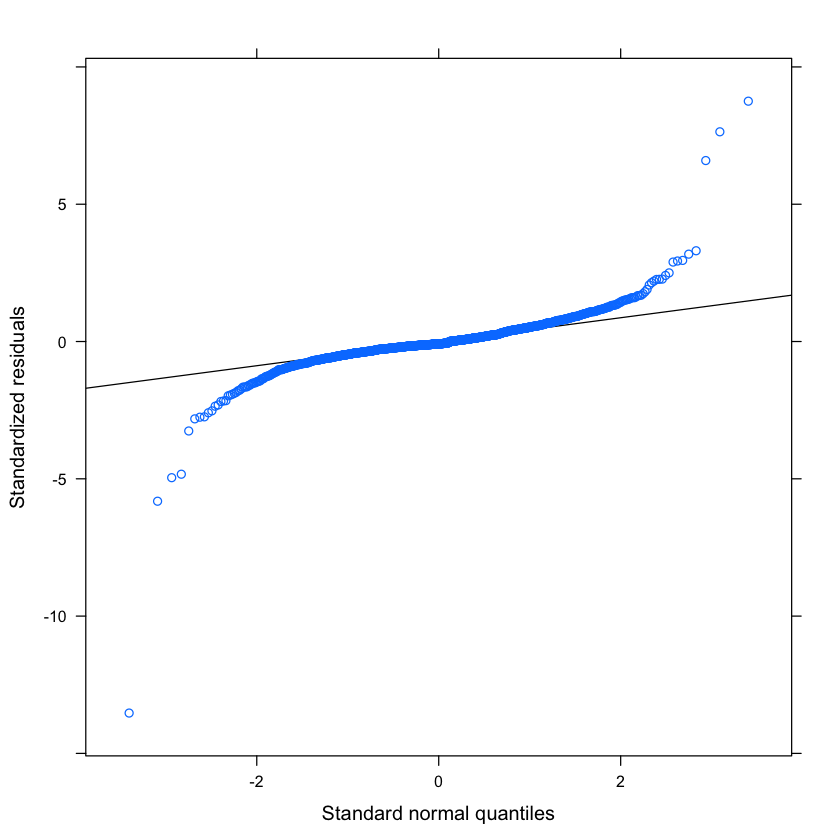

In [272]:
qqmath(model_3)

In [273]:
# just differing trajectories variables, rand intercept
model_4 = glmer(PREVHYP ~ CIGPDAY + SYSBP + (1 | RANDID),
                data=framingham_data_clean,
                family=binomial)
summary(model_4)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?;Model is nearly unidentifiable: large eigenvalue ratio
 - Rescale variables?”

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: PREVHYP ~ CIGPDAY + SYSBP + (1 | RANDID)
   Data: framingham_data_clean

     AIC      BIC   logLik deviance df.resid 
  1157.5   1178.8   -574.8   1149.5     1496 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-16.8991  -0.3056  -0.0868   0.3112   8.1287 

Random effects:
 Groups Name        Variance Std.Dev.
 RANDID (Intercept) 2.103    1.45    
Number of obs: 1500, groups:  RANDID, 500

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -20.311035   1.347110 -15.077   <2e-16 ***
CIGPDAY      -0.016804   0.008393  -2.002   0.0453 *  
SYSBP         0.150212   0.009932  15.125   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr) CIGPDA
CIGPDAY  0.016       
SYSBP   -0.995 -0.066
convergence code: 0
Model is nearly unidentifiable: very

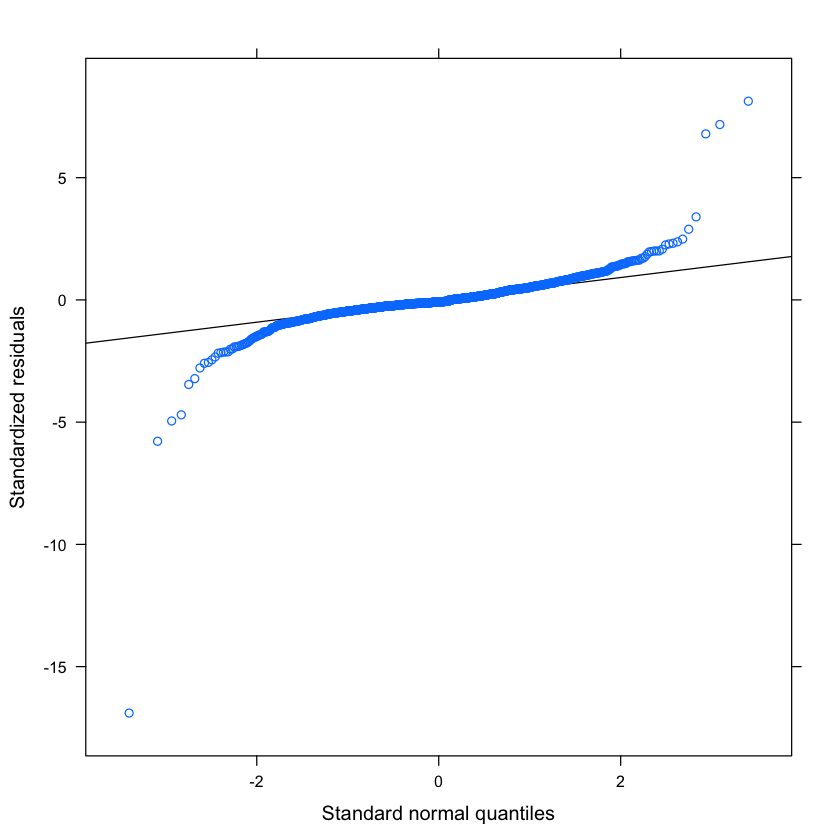

In [274]:
qqmath(model_4)

In [275]:
anova(model_1, model_2, model_3, model_4)

Df AIC       BIC      logLik    deviance  Chisq      Chi Df
model_4  4 1157.5267 1178.780 -574.7633 1149.5267         NA NA    
model_3  9 1149.4816 1197.301 -565.7408 1131.4816  18.045024  5    
model_2 17  950.2637 1040.588 -458.1318  916.2637 215.217954  8    
model_1 19  952.4222 1053.373 -457.2111  914.4222   1.841491  2    
        Pr(>Chisq)  
model_4           NA
model_3 2.890503e-03
model_2 3.940688e-42
model_1 3.982220e-01

In [251]:
# AIC and BIC are similar for model_1 and model_2, however, 2 is simpler, has slightly better AIC/BIC overall, and has much better Chisq
final_model = model_2

## Model Evaluation

Area under the curve: 0.9942


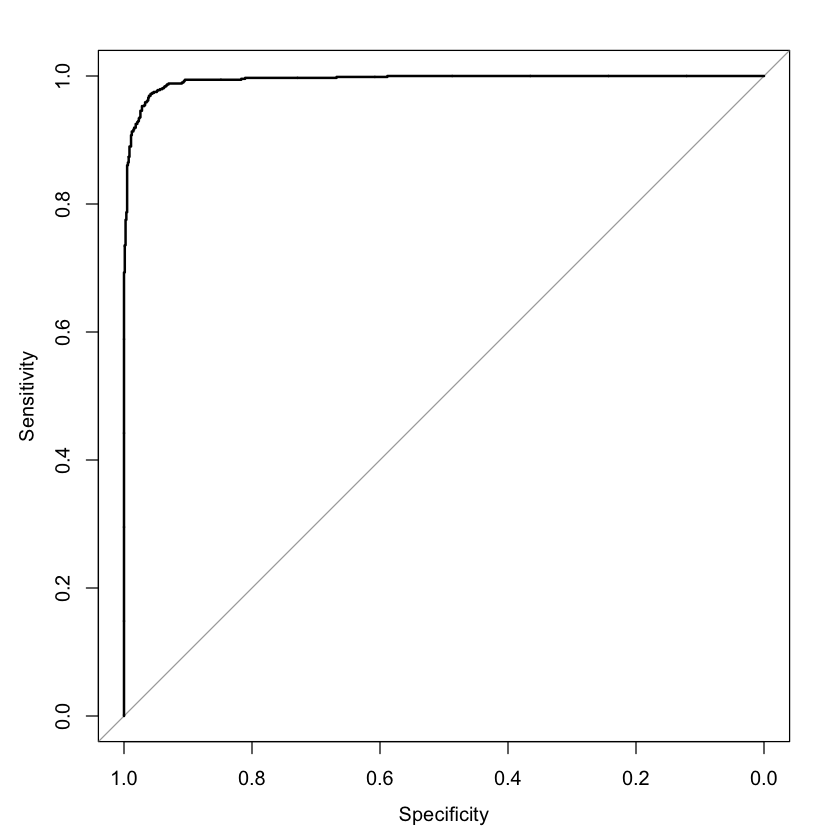

In [252]:
pred = predict(final_model, cbind(framingham_data_clean[1:13], framingham_data_clean[15:16]))
roc.curve = roc(framingham_data_clean$PREVHYP, pred)
print(pROC::auc(roc.curve))
plot(roc.curve)

Area under the curve: 0.9937


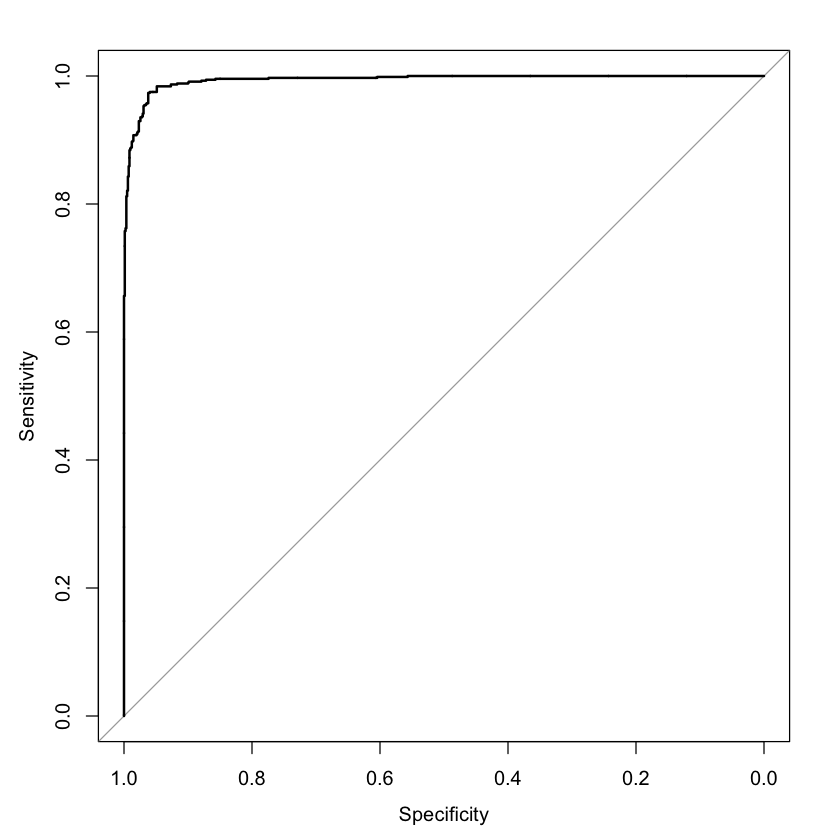

In [280]:
pred = predict(model_1, cbind(framingham_data_clean[1:13], framingham_data_clean[15:16]))
roc.curve = roc(framingham_data_clean$PREVHYP, pred)
print(pROC::auc(roc.curve))
plot(roc.curve)

Area under the curve: 0.9631


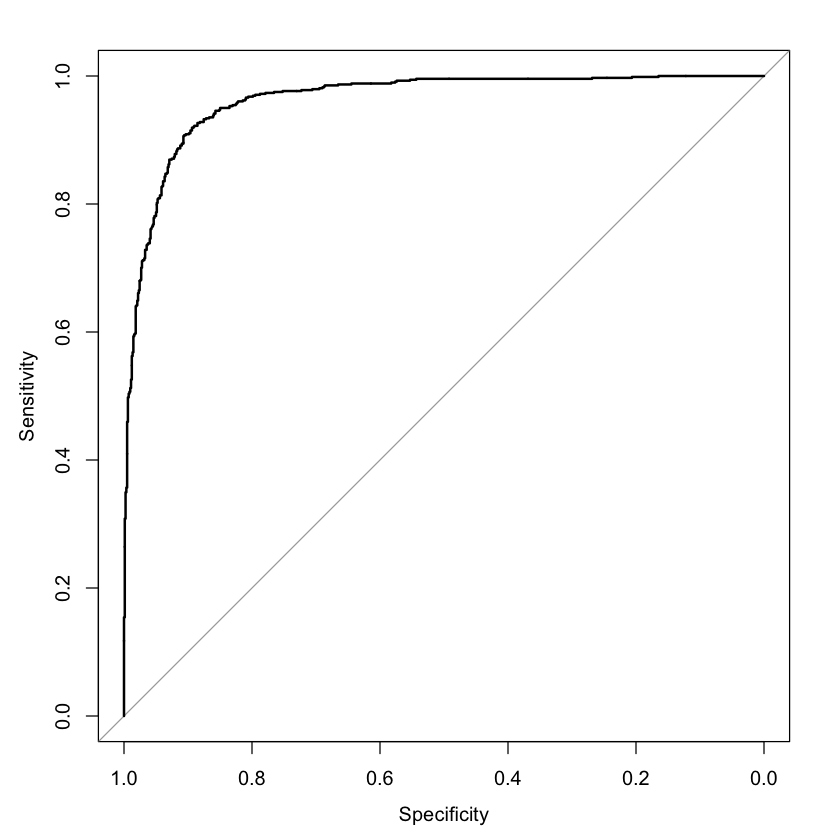

In [254]:
pred = predict(model_3, cbind(framingham_data_clean[1:13], framingham_data_clean[15:16]))
roc.curve = roc(framingham_data_clean$PREVHYP, pred)
print(pROC::auc(roc.curve))
plot(roc.curve)

Area under the curve: 0.964


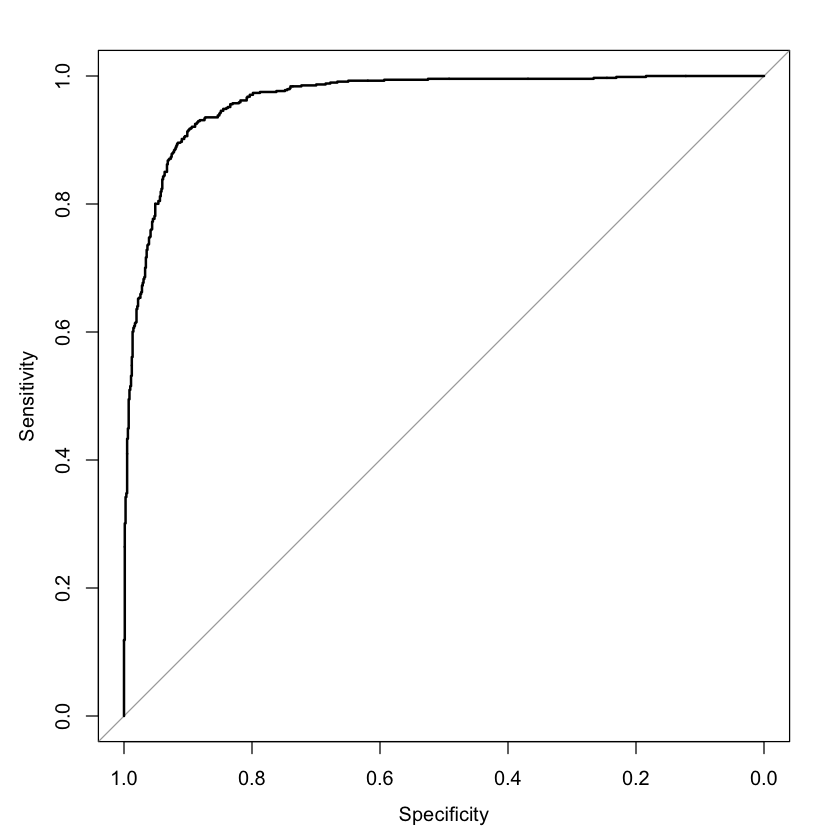

In [255]:
pred = predict(model_4, cbind(framingham_data_clean[1:13], framingham_data_clean[15:16]))
roc.curve = roc(framingham_data_clean$PREVHYP, pred)
print(pROC::auc(roc.curve))
plot(roc.curve)

In [ ]:
# compare to analysis 5 code in write up/include roc curves